In [1]:
#exploratory
import os

import numpy as np
import pandas as pd

from trackml.dataset import load_event
from trackml.randomize import shuffle_hits
from trackml.score import score_event
from sklearn import preprocessing

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline



In [2]:
event_prefix = 'event000001000'
hits, cells, particles, truth = load_event(os.path.join('train_1', event_prefix))

mem_bytes = (hits.memory_usage(index=True).sum() 
             + cells.memory_usage(index=True).sum() 
             + particles.memory_usage(index=True).sum() 
             + truth.memory_usage(index=True).sum())
print('{} memory usage {:.2f} MB'.format(event_prefix, mem_bytes / 2**20))

event000001000 memory usage 18.46 MB


In [3]:
hits.head(10)

hit_id          x          y       z  volume_id  layer_id  module_id
0       1 -64.409897  -7.163700 -1502.5          7         2          1
1       2 -55.336102   0.635342 -1502.5          7         2          1
2       3 -83.830498  -1.143010 -1502.5          7         2          1
3       4 -96.109100  -8.241030 -1502.5          7         2          1
4       5 -62.673599  -9.371200 -1502.5          7         2          1
5       6 -57.068699  -8.177770 -1502.5          7         2          1
6       7 -73.872299  -2.578900 -1502.5          7         2          1
7       8 -63.853500 -10.868400 -1502.5          7         2          1
8       9 -97.254799 -10.889100 -1502.5          7         2          1
9      10 -90.292900  -3.269370 -1502.5          7         2          1

In [4]:
cells.head(10)

hit_id  ch0  ch1     value
0       1  209  617  0.013832
1       1  210  617  0.079887
2       1  209  618  0.211723
3       2   68  446  0.334087
4       3   58  954  0.034005
5       3   58  956  0.007798
6       3   60  951  0.019897
7       3   58  955  0.099964
8       3   59  952  0.065576
9       3   60  952  0.018697

In [5]:
particles.head()

particle_id        vx        vy        vz         px         py  \
0  4503668346847232 -0.009288  0.009861 -0.077879  -0.055269   0.323272   
1  4503737066323968 -0.009288  0.009861 -0.077879  -0.948125   0.470892   
2  4503805785800704 -0.009288  0.009861 -0.077879  -0.886484   0.105749   
3  4503874505277440 -0.009288  0.009861 -0.077879   0.257539  -0.676718   
4  4503943224754176 -0.009288  0.009861 -0.077879  16.439400 -15.548900   

          pz  q  nhits  
0  -0.203492 -1      8  
1   2.010060  1     11  
2   0.683881 -1      0  
3   0.991616  1     12  
4 -39.824902  1      3

In [6]:
truth.head(10)

hit_id         particle_id         tx         ty      tz            tpx  \
0       1                   0 -64.411598  -7.164120 -1502.5  250710.000000   
1       2   22525763437723648 -55.338501   0.630805 -1502.5      -0.570605   
2       3                   0 -83.828003  -1.145580 -1502.5  626295.000000   
3       4  297237712845406208 -96.122902  -8.230360 -1502.5      -0.225235   
4       5  418835796137607168 -62.659401  -9.375040 -1502.5      -0.281806   
5       6  108087696726949888 -57.085602  -8.189710 -1502.5      -0.401129   
6       7  968286151951515648 -73.860802  -2.575860 -1502.5      -0.442662   
7       8  954766419537428480 -63.851200 -10.875400 -1502.5      -0.670459   
8       9  707072769359085568 -97.248901 -10.906700 -1502.5      -0.279789   
9      10   67554956483231744 -90.276299  -3.243970 -1502.5      -0.251752   

             tpy           tpz    weight  
0 -149908.000000 -956385.00000  0.000000  
1       0.028390     -15.49220  0.000010  
2 -169767.000000 -760877.00000  0.000000  
3      -0.050968      -3.70232  0.000008  
4      -0.023487      -6.57318  0.000009  
5      -0.035276     -10.46690  0.000008  
6      -0.036969      -9.13010  0.000007  
7      -0.092609     -15.54070  0.000011  
8      -0.062143      -4.41292  0.000008  
9      -0.037138      -4.24922  0.000006

In [7]:
df = truth.merge(particles,on='particle_id')
df = df.merge(hits,on='hit_id')[['hit_id','particle_id','x','y','z']]
#df['track_id'] = pd.Series()
dict={}
for track,particle in enumerate(df.particle_id.unique()):
  dict[particle]=track
df['track_id'] = df.particle_id.map(dict)
df

hit_id         particle_id           x           y       z  track_id
0            2   22525763437723648  -55.336102    0.635342 -1502.5         0
1         1420   22525763437723648  -55.162201    0.604841 -1497.5         0
2         1460   22525763437723648  -47.975498    0.311848 -1302.5         0
3         3170   22525763437723648  -47.812302    0.327322 -1297.5         0
4         3234   22525763437723648  -40.622799    0.088046 -1102.5         0
5         5343   22525763437723648  -40.438801    0.098098 -1097.5         0
6         5424   22525763437723648  -35.480598   -0.008800  -962.5         0
7         5482   22525763437723648  -35.330101   -0.023294  -958.0         0
8         7867   22525763437723648  -35.312302   -0.004440  -957.5         0
9         7951   22525763437723648  -30.333700   -0.105277  -822.5         0
10           4  297237712845406208  -96.109100   -8.241030 -1502.5         1
11        1461  297237712845406208  -83.871597   -5.572670 -1302.5         1
12        3231  297237712845406208  -71.576302   -3.351140 -1102.5         1
13        5405  297237712845406208  -62.745602   -2.004140  -962.5         1
14        7889  297237712845406208  -62.434700   -1.932390  -957.5         1
15        7954  297237712845406208  -53.856800   -0.953498  -822.5         1
16       10744  297237712845406208  -53.518398   -0.928854  -817.5         1
17       10837  297237712845406208  -46.066101   -0.290200  -702.5         1
18       13782  297237712845406208  -45.758900   -0.285674  -697.5         1
19       13866  297237712845406208  -39.545502    0.022362  -602.5         1
20       16847  297237712845406208  -39.213600    0.051823  -597.5         1
21           5  418835796137607168  -62.673599   -9.371200 -1502.5         2
22          38  418835796137607168  -62.473598   -9.368010 -1498.0         2
23        1468  418835796137607168  -54.161701   -8.550840 -1302.5         2
24        1513  418835796137607168  -53.989101   -8.565160 -1298.0         2
25        3244  418835796137607168  -45.713699   -7.635200 -1102.5         2
26        3302  418835796137607168  -45.514000   -7.610320 -1098.0         2
27        5415  418835796137607168  -39.845299   -6.922570  -962.5         2
28        5489  418835796137607168  -39.655998   -6.872400  -958.0         2
29        7959  418835796137607168  -34.012001   -6.112390  -822.5         2
...        ...                 ...         ...         ...     ...       ...
103275  119147  540435253836132354 -719.033020 -343.483002  1794.5     10540
103276  119236  409841103827632128  324.815002 -797.093018  1797.5     10541
103277  119245  409841103827632128  327.950989 -805.002991  1802.5     10541
103278  119242  409841172547108864  292.164001 -786.210999  1797.5     10542
103279  119664  409841172547108864  332.053009 -937.604980  2152.5     10542
103280  119347  887211737948884993  671.120972  370.096008  1794.5     10543
103281  119416  445864678183149570   24.605600  755.208008  1794.5     10544
103282  119417  306246423945420802   70.287598  752.213989  1794.5     10545
103283  119810  306246423945420802  310.407013  856.690979  2155.5     10545
103284  119481  689055553367838721 -645.955017  550.765991  1797.5     10546
103285  119578  648523019282554882 -685.965027 -519.901001  2147.5     10547
103286  119585  648523019282554882 -694.666016 -523.906006  2152.5     10547
103287  119587  648523019282554882 -685.778992 -521.129028  2144.5     10547
103288  119634  684562124223029250  -43.398499 -837.354004  2144.5     10548
103289  119731  135110325300109314  808.096985  -12.739400  2144.5     10549
103290  119737  220679336695435265  947.427979 -108.963997  2155.5     10550
103291  119997  292749987450720257 -868.502014 -391.179993  2552.5     10551
103292  120070  873706505344393218 -132.261993 -786.101990  2547.5     10552
103293  120087  842174848321986562   31.653799 -775.590027  2547.5     10553
103294  120461  166642188480942081 -782.039978 -152.682007  2944.5     10554
1032

In [8]:
le = preprocessing.LabelEncoder()
df = truth.merge(particles,on='particle_id')
df = df.merge(hits,on='hit_id')[['hit_id','particle_id','x','y','z']]
le.fit(df['particle_id'])
df['track_id'] = le.transform(df['particle_id'])
df

hit_id         particle_id           x           y       z  track_id
0            2   22525763437723648  -55.336102    0.635342 -1502.5       476
1         1420   22525763437723648  -55.162201    0.604841 -1497.5       476
2         1460   22525763437723648  -47.975498    0.311848 -1302.5       476
3         3170   22525763437723648  -47.812302    0.327322 -1297.5       476
4         3234   22525763437723648  -40.622799    0.088046 -1102.5       476
5         5343   22525763437723648  -40.438801    0.098098 -1097.5       476
6         5424   22525763437723648  -35.480598   -0.008800  -962.5       476
7         5482   22525763437723648  -35.330101   -0.023294  -958.0       476
8         7867   22525763437723648  -35.312302   -0.004440  -957.5       476
9         7951   22525763437723648  -30.333700   -0.105277  -822.5       476
10           4  297237712845406208  -96.109100   -8.241030 -1502.5      3555
11        1461  297237712845406208  -83.871597   -5.572670 -1302.5      3555
12        3231  297237712845406208  -71.576302   -3.351140 -1102.5      3555
13        5405  297237712845406208  -62.745602   -2.004140  -962.5      3555
14        7889  297237712845406208  -62.434700   -1.932390  -957.5      3555
15        7954  297237712845406208  -53.856800   -0.953498  -822.5      3555
16       10744  297237712845406208  -53.518398   -0.928854  -817.5      3555
17       10837  297237712845406208  -46.066101   -0.290200  -702.5      3555
18       13782  297237712845406208  -45.758900   -0.285674  -697.5      3555
19       13866  297237712845406208  -39.545502    0.022362  -602.5      3555
20       16847  297237712845406208  -39.213600    0.051823  -597.5      3555
21           5  418835796137607168  -62.673599   -9.371200 -1502.5      4810
22          38  418835796137607168  -62.473598   -9.368010 -1498.0      4810
23        1468  418835796137607168  -54.161701   -8.550840 -1302.5      4810
24        1513  418835796137607168  -53.989101   -8.565160 -1298.0      4810
25        3244  418835796137607168  -45.713699   -7.635200 -1102.5      4810
26        3302  418835796137607168  -45.514000   -7.610320 -1098.0      4810
27        5415  418835796137607168  -39.845299   -6.922570  -962.5      4810
28        5489  418835796137607168  -39.655998   -6.872400  -958.0      4810
29        7959  418835796137607168  -34.012001   -6.112390  -822.5      4810
...        ...                 ...         ...         ...     ...       ...
103275  119147  540435253836132354 -719.033020 -343.483002  1794.5      5754
103276  119236  409841103827632128  324.815002 -797.093018  1797.5      4800
103277  119245  409841103827632128  327.950989 -805.002991  1802.5      4800
103278  119242  409841172547108864  292.164001 -786.210999  1797.5      4801
103279  119664  409841172547108864  332.053009 -937.604980  2152.5      4801
103280  119347  887211737948884993  671.120972  370.096008  1794.5      9780
103281  119416  445864678183149570   24.605600  755.208008  1794.5      5167
103282  119417  306246423945420802   70.287598  752.213989  1794.5      3764
103283  119810  306246423945420802  310.407013  856.690979  2155.5      3764
103284  119481  689055553367838721 -645.955017  550.765991  1797.5      7206
103285  119578  648523019282554882 -685.965027 -519.901001  2147.5      6525
103286  119585  648523019282554882 -694.666016 -523.906006  2152.5      6525
103287  119587  648523019282554882 -685.778992 -521.129028  2144.5      6525
103288  119634  684562124223029250  -43.398499 -837.354004  2144.5      7157
103289  119731  135110325300109314  808.096985  -12.739400  2144.5      1735
103290  119737  220679336695435265  947.427979 -108.963997  2155.5      2729
103291  119997  292749987450720257 -868.502014 -391.179993  2552.5      3507
103292  120070  873706505344393218 -132.261993 -786.101990  2547.5      9507
103293  120087  842174848321986562   31.653799 -775.590027  2547.5      8991
103294  120461  166642188480942081 -782.039978 -152.682007  2944.5      2210
1032

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


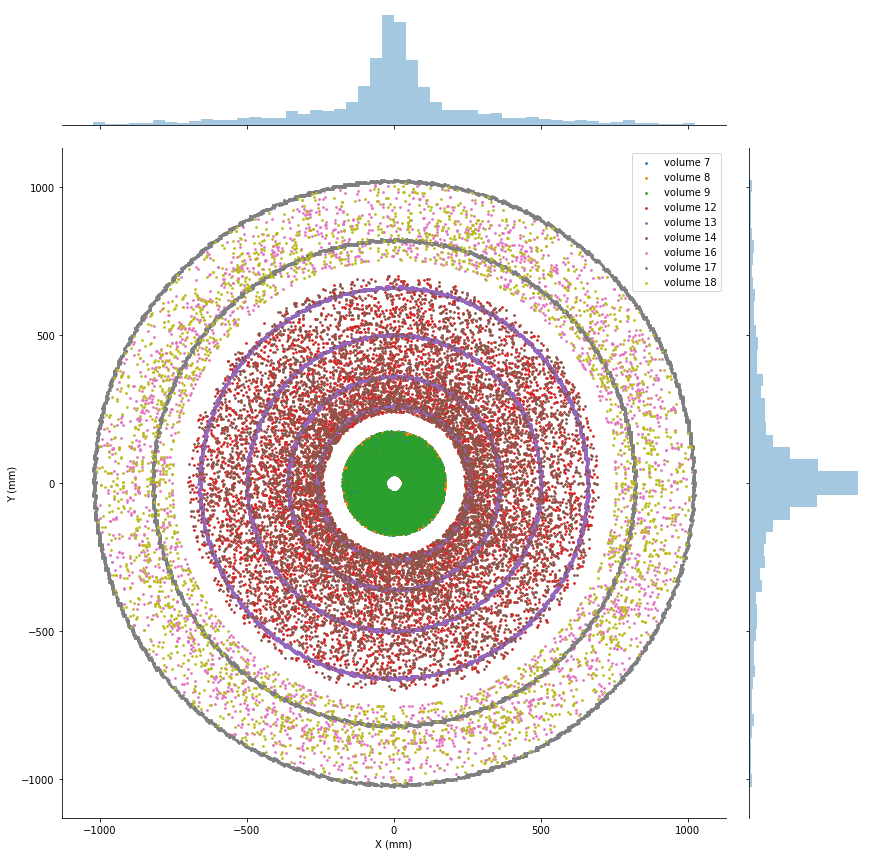

In [9]:
g = sns.jointplot(hits.x, hits.y,  s=1, size=12)
g.ax_joint.cla()
plt.sca(g.ax_joint)

volumes = hits.volume_id.unique()
for volume in volumes:
    v = hits[hits.volume_id == volume]
    plt.scatter(v.x, v.y, s=3, label='volume {}'.format(volume))

plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.legend()
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


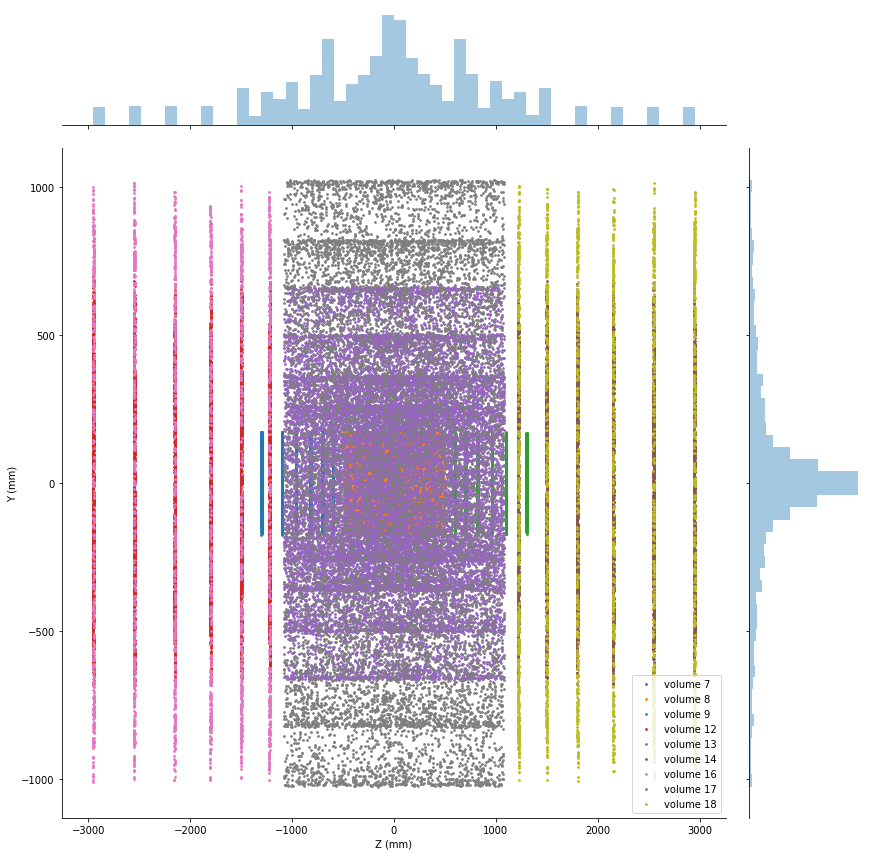

In [10]:
g = sns.jointplot(hits.z, hits.y, s=1, size=12)
g.ax_joint.cla()
plt.sca(g.ax_joint)

volumes = hits.volume_id.unique()
for volume in volumes:
    v = hits[hits.volume_id == volume]
    plt.scatter(v.z, v.y, s=3, label='volume {}'.format(volume))

plt.xlabel('Z (mm)')
plt.ylabel('Y (mm)')
plt.legend()
plt.show()

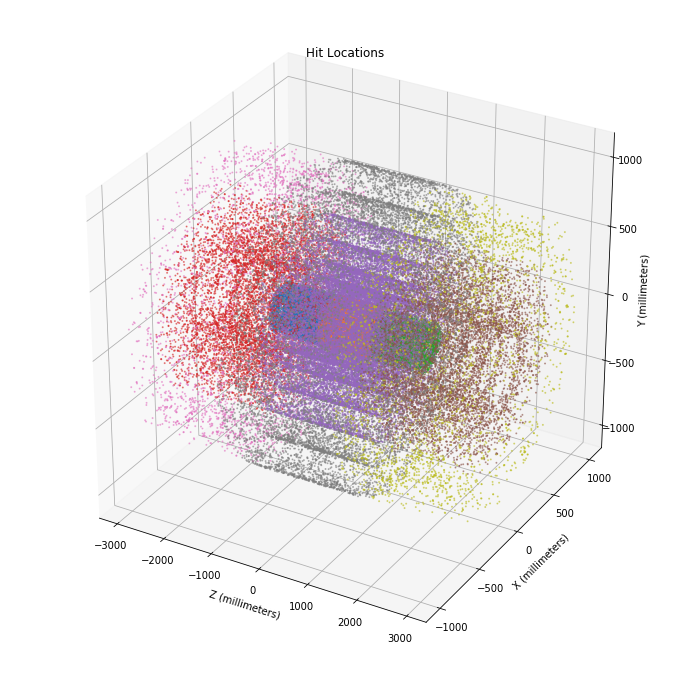

In [11]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
for volume in volumes:
    v = hits[hits.volume_id == volume]
    ax.scatter(v.z, v.x, v.y, s=1, label='volume {}'.format(volume), alpha=0.5)
ax.set_title('Hit Locations')
ax.set_xlabel('Z (millimeters)')
ax.set_ylabel('X (millimeters)')
ax.set_zlabel('Y (millimeters)')
plt.show()

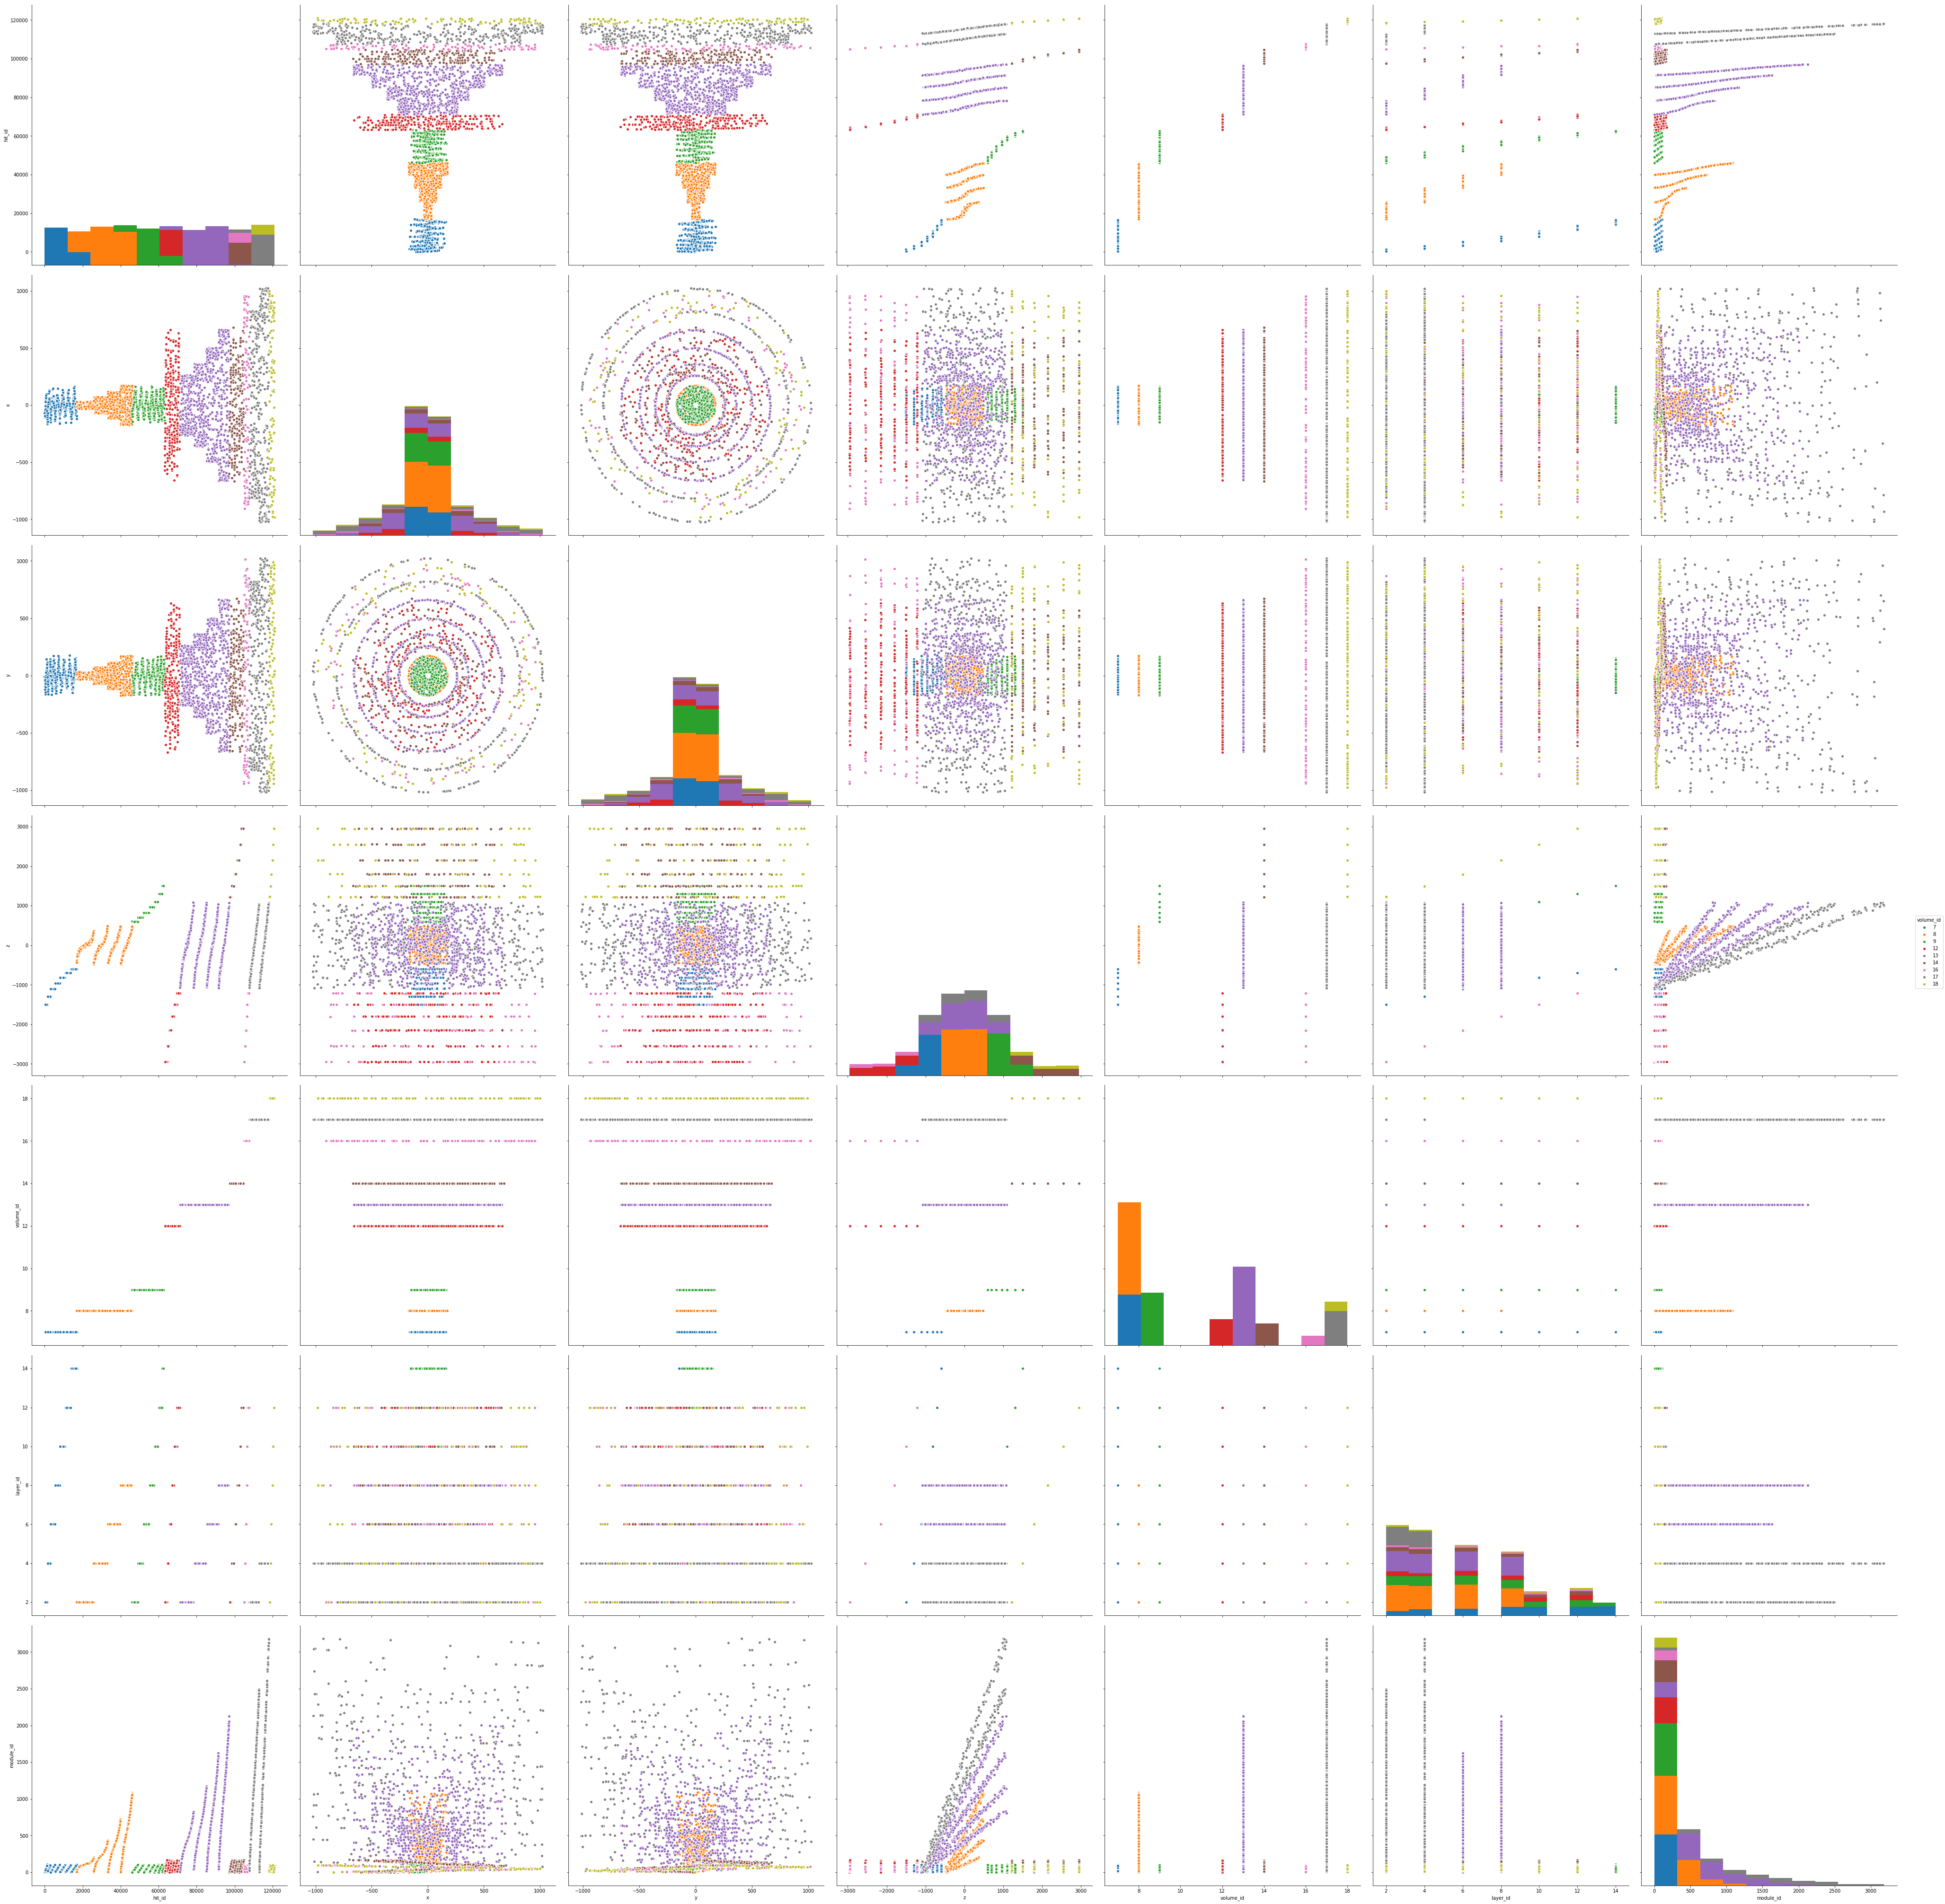

In [12]:
hits_sample = hits.sample(4000)
sns.pairplot(hits_sample, hue='volume_id', size=8)
plt.show()

<class 'pandas.core.series.Series'>


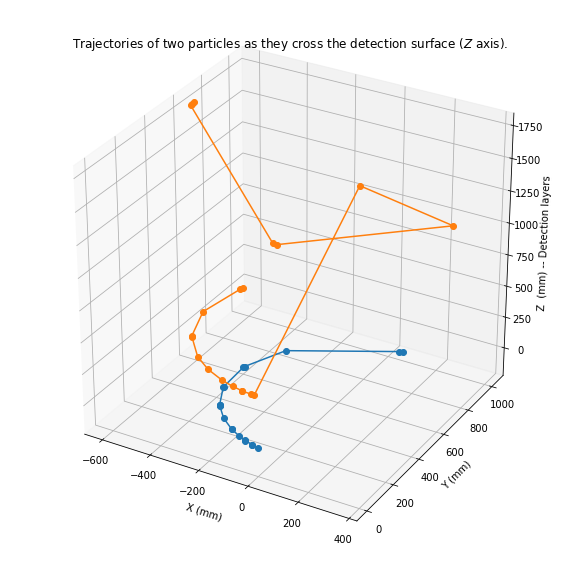

In [13]:
# Get particle id with max number of hits in this event
particle = particles.loc[particles.nhits == particles.nhits.max()].iloc[0]
print(type(particle))
particle2 = particles.loc[particles.nhits == particles.nhits.max()].iloc[1]

# Get points where the same particle intersected subsequent layers of the observation material
p_traj_surface = truth[truth.particle_id == particle.particle_id][['tx', 'ty', 'tz']]
p_traj_surface2 = truth[truth.particle_id == particle2.particle_id][['tx', 'ty', 'tz']]

p_traj = (p_traj_surface
          .append({'tx': particle.vx, 'ty': particle.vy, 'tz': particle.vz}, ignore_index=True)
          .sort_values(by='tz'))
p_traj2 = (p_traj_surface2
          .append({'tx': particle2.vx, 'ty': particle2.vy, 'tz': particle2.vz}, ignore_index=True)
          .sort_values(by='tz'))


#print(p_traj)
#print(p_traj_surface)


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.plot(
    xs=p_traj.tx,
    ys=p_traj.ty,
    zs=p_traj.tz, marker='o')
ax.plot(
    xs=p_traj2.tx,
    ys=p_traj2.ty,
    zs=p_traj2.tz, marker='o')

ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z  (mm) -- Detection layers')
plt.title('Trajectories of two particles as they cross the detection surface ($Z$ axis).')
plt.show()

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
               tx          ty          tz
24087   25.649500   19.221901  117.891998
32265   57.968601   43.886501  262.540009
39521   92.509499   70.731697  418.088013
47952  132.106995  102.220001  598.000000


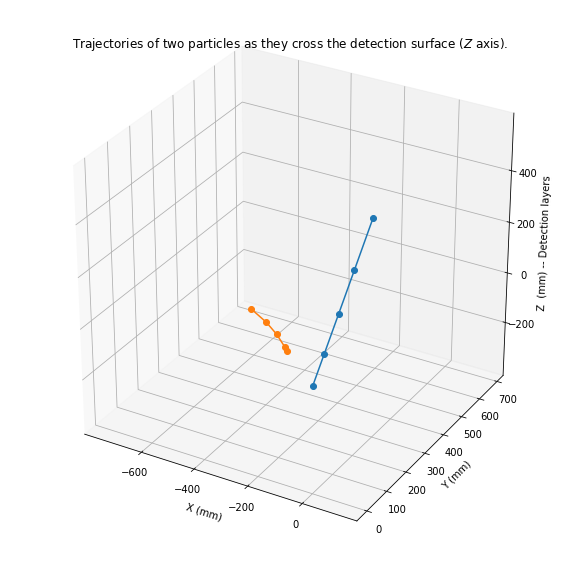

In [14]:
# Get particle id with max number of hits in this event
particle1 = truth.sort_values('weight', ascending=False).iloc[7]
particle2 = truth.sort_values('weight', ascending=False).iloc[8]

print(type(particle1))

# Get points where the same particle intersected subsequent layers of the observation material
p_traj_surface1 = truth[truth.particle_id == particle1.particle_id][['tx', 'ty', 'tz']]
p_traj_surface2 = truth[truth.particle_id == particle2.particle_id][['tx', 'ty', 'tz']]

p_traj_orig1 = particles[particles.particle_id == particle1.particle_id][['vx', 'vy', 'vz']].iloc[0]
p_traj_orig2 = particles[particles.particle_id == particle2.particle_id][['vx', 'vy', 'vz']].iloc[0]

print(type(p_traj_orig1))

#print({'tx': p_traj_orig1.vx, 'ty': p_traj_orig1.vy, 'tz': p_traj_orig1.vz})

p_traj1 = (p_traj_surface1
          .append({'tx': p_traj_orig1.vx, 'ty': p_traj_orig1.vy, 'tz': p_traj_orig1.vz}, ignore_index=True)
          .sort_values(by='tz'))
p_traj2 = (p_traj_surface2
          .append({'tx':p_traj_orig2.vx, 'ty': p_traj_orig2.vy, 'tz': p_traj_orig2.vz}, ignore_index=True)
          .sort_values(by='tz'))

print(p_traj_surface1)


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.plot(
    xs=p_traj1.tx,
    ys=p_traj1.ty,
    zs=p_traj1.tz, marker='o')
ax.plot(
    xs=p_traj2.tx,
    ys=p_traj2.ty,
    zs=p_traj2.tz, marker='o')

ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z  (mm) -- Detection layers')
plt.title('Trajectories of two particles as they cross the detection surface ($Z$ axis).')
plt.show()